### Obesity Level Prediction using Logistic Regression
This notebook applies logisitc regression to predict obesity levels based on lifestyle and demographic variables. 

/opt/miniconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:124

Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best cross-validation accuracy: 0.9260

Test Set Performance:
Accuracy: 0.9243

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.98      0.95        56
      Normal_Weight       0.96      0.81      0.88        62
     Obesity_Type_I       1.00      0.92      0.96        78
    Obesity_Type_II       0.94      1.00      0.97        58
   Obesity_Type_III       0.98      1.00      0.99        63
 Overweight_Level_I       0.79      0.88      0.83        56
Overweight_Level_II       0.86      0.88      0.87        50

           accuracy                           0.92       423
          macro avg       0.92      0.92      0.92       423
       weighted avg       0.93      0.92      0.92       423



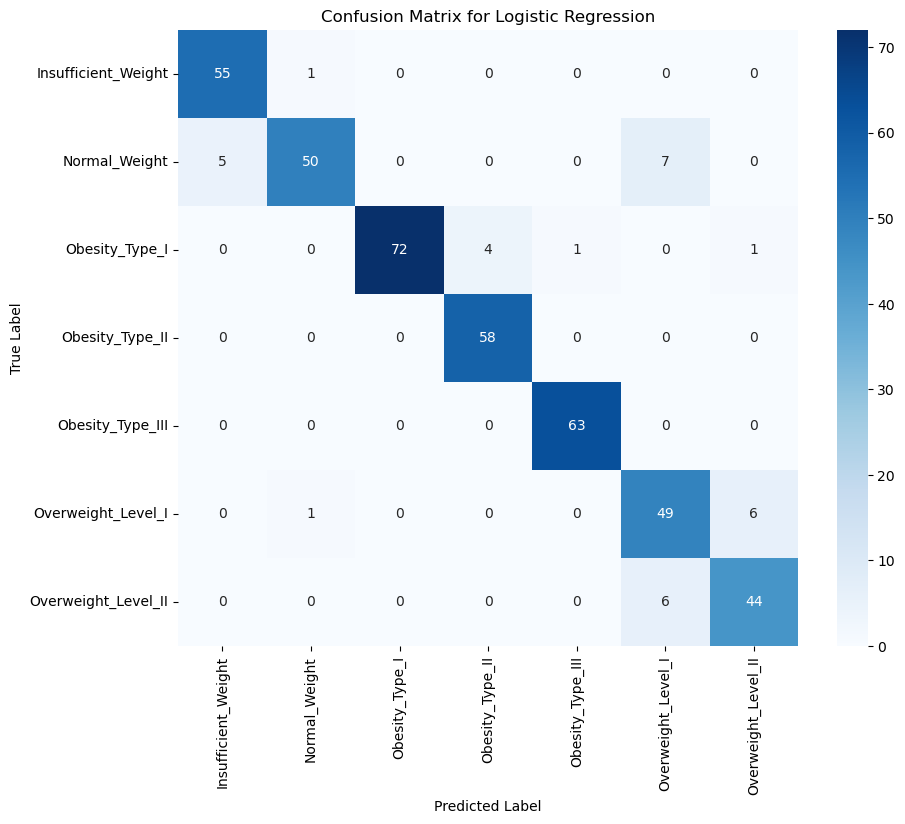

In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Load split data from feather files
train_path = os.path.join("..", "processed_data", "train_data.feather")
test_path = os.path.join("..", "processed_data", "test_data.feather")

train_df = pd.read_feather(train_path)
test_df = pd.read_feather(test_path)

# Split features and labels
y_train = train_df["obesity_level"]
X_train = train_df.drop(columns=["obesity_level"])

y_test = test_df["obesity_level"]
X_test = test_df.drop(columns=["obesity_level"])

# Define numerical columns
numerical_cols = X_train.select_dtypes(include=["float64"]).columns.tolist()

# Separate nominal and ordinal categorical features
nominal_cols = [
    'gender', 
    'family_history_overweight', 
    'smokes', 
    'calorie_tracking', 
    'transport_mode'
]

ordinal_cols = [
    'high_caloric_food_freq', 
    'vegetables_freq', 
    'main_meal_count', 
    'snacking_freq', 
    'water_intake', 
    'physical_activity_freq', 
    'screen_time_hours', 
    'alcohol_consumption_freq'
]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("nom", OneHotEncoder(handle_unknown='ignore'), nominal_cols),
        ("ord", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)
    ]
)

# Encode the target variable (necessary for classification)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create pipeline
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='saga', random_state=42))
])

# Define parameter grid for Logistic Regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization strength (inverse)
    'classifier__penalty': ['l2']          # L2 regularization
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

# Get the best model
best_lr = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_lr.predict(X_test)
test_accuracy = accuracy_score(y_test_encoded, y_pred)
print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix 
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


### Confusion Matrix Explanation 
The confusion  matrix shows how well a model's predictions match the actual labels. Some insights from the confusion matrix are:

- Misclassifications are more frequent in the "Normal_Weight" and "Overweight_Level_I/II" classes. The model struggles more with these compared to the obesity types, likely due to <strong>class overlap</strong> or underrepresentation in the data. This may guide sampling adjustments or weighted loss functions. 

- "Insufficient_Weight" has high <strong>precision(0.92)</strong> and very high <strong>recall(0.88)</strong> meaning the model rarely misclassifies others as this class and identifies it well. 

- "Overweight_Level_I" and "Overweight_Level_II" both have <strong>lower recall(0.88)</strong> and <strong>F-1 scores(~0.83 - 0.87)</strong> highlighting weakness in distinguishing between these classes. This may show <strong>which predictions you can trust more than others</strong> which can be critical in medical contexts. 

- Additionally, the confusion between "Normal_Weight" and "Overweight_Level_I" suggests features (e.g. calorie tracking or exercise) are not distinctive enough between these classes. 

#### Summary 
- Best logisitc regression parameters: $C = 10$, Penalty = $L2$
- Cross-validation Accuracy: $92.6%$
- Test Set Accuracy: $92.4%$
- Logistic regression performs well across most classes with minor misclassification in closely related categories (e.g. Overweight I vs II).